In [ ]:
!pip install transformers
!pip install diffusers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 100.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 113.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.9/934.9 kB 49.1 MB/s eta 0:00:00


In [ ]:
pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from IPython.display import Audio

from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms

from scipy.signal import istft
from scipy.io import wavfile
import pydub

from __future__ import annotations
import typing as T
from dataclasses import dataclass
from enum import Enum

import pandas as pd
import numpy as np  
import torch
from torch.utils.data import Dataset, DataLoader
from huggingface_hub import notebook_login
from diffusers import DiffusionPipeline, StableDiffusionPipeline, StableDiffusionImg2ImgPipeline
from transformers import TrainingArguments, Trainer, AutoTokenizer 

import librosa 
from sklearn.model_selection import train_test_split
import shutil
import os
import librosa 

from IPython.display import Audio
import librosa 

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [ ]:
model_id = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to("cuda")

prompt = "provide a piece of music"
image = pipe(prompt).images[0]  
    


Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
image.save("music.png")

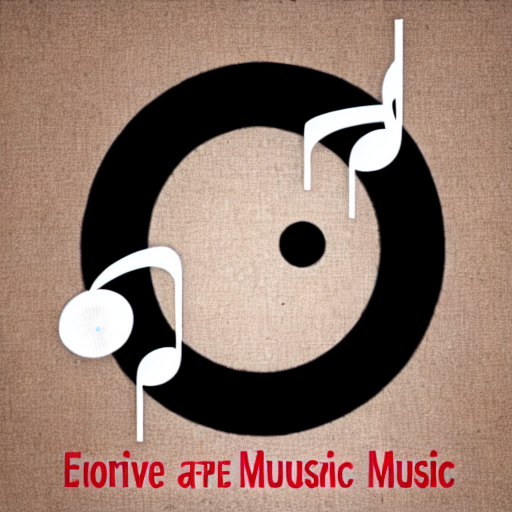

In [ ]:
image

In [ ]:
image_width = 512
sample_rate = 44100  # [Hz]
clip_duration_ms = 5000  # [ms]

bins_per_image = 512
n_mels = 512

# FFT parameters
window_duration_ms = 100  # [ms]
padded_duration_ms = 400  # [ms]
step_size_ms = 10  # [ms]

# Derived parameters
num_samples = int(image_width / float(bins_per_image) * clip_duration_ms) * sample_rate
n_fft = int(padded_duration_ms / 1000.0 * sample_rate)
hop_length = int(step_size_ms / 1000.0 * sample_rate)
win_length = int(window_duration_ms / 1000.0 * sample_rate)

In [ ]:
def spectrogram_from_waveform(
    waveform: np.ndarray,
    params,
    n_fft=n_fft,
    hop_length=hop_length,
    win_length=win_length,
    mel_scale: bool = True):

    spectrogram_func = torchaudio.transforms.Spectrogram(
        n_fft=n_fft,
        power=None,
        hop_length=hop_length,
        win_length=win_length,
    )

    waveform_tensor = torch.from_numpy(waveform.astype(np.float32)).reshape(1, -1)
    Sxx_complex = spectrogram_func(waveform_tensor).numpy()[0]

    Sxx_mag = np.abs(Sxx_complex)

    if mel_scale:
        mel_scaler = torchaudio.transforms.MelScale(
            n_mels=params.num_frequencies,
            sample_rate=params.sample_rate,
            f_min=params.min_frequency,
            f_max=params.max_frequency,
            n_stft=n_fft // 2 + 1,
            norm=params.mel_scale_norm,
            mel_scale=params.mel_scale_type,
        )

        Sxx_mag = mel_scaler(torch.from_numpy(Sxx_mag)).numpy()

    return Sxx_mag

In [ ]:
def image_from_spectrogram(spectrogram: np.ndarray, params, max_volume: float = 50):

    data = np.power(spectrogram, params.power_for_image)
    data = data * 255 / max_volume
    data = 255 - data
    image = Image.fromarray(data.astype(np.uint8))
    image = image.transpose(Image.FLIP_TOP_BOTTOM)
    image = image.convert("RGB")

    return image

In [ ]:
def spectrogram_from_image(
    image: Image.Image, params, max_volume: float = 50):

    data = np.array(image).astype(np.float32)
    data = data[::-1, :, 0]
    data = 255 - data
    data = data * max_volume / 255
    data = np.power(data, 1 / params.power_for_image)

    return data

In [ ]:
def waveform_from_spectrogram(
    Sxx: np.ndarray,
    params,
    n_fft=n_fft,
    hop_length=hop_length,
    win_length=win_length,
    num_samples=num_samples,
    mel_scale: bool = True,
    device: str = "cpu"):

    Sxx_torch = torch.from_numpy(Sxx).to(device)

    if mel_scale:
        mel_inv_scaler = torchaudio.transforms.InverseMelScale(
            n_mels=params.num_frequencies,
            sample_rate= params.sample_rate,
            f_min=params.min_frequency,
            f_max=params.max_frequency,
            n_stft=n_fft // 2 + 1,
            norm=params.mel_scale_norm,
            mel_scale=params.mel_scale_type,
            max_iter=params.max_mel_iters,
        ).to(device)

        Sxx_torch = mel_inv_scaler(Sxx_torch)

    griffin_lim = torchaudio.transforms.GriffinLim(
        n_fft=n_fft,
        win_length=win_length,
        hop_length=hop_length,
        power=1.0,
        n_iter=params.num_griffin_lim_iters,
    ).to(device)

    waveform = griffin_lim(Sxx_torch).cpu().numpy()

    return waveform

In [ ]:
class Params_Mono:
    def __init__(self):
        self.image_width = 512
        self.sample_rate = 44100  # [Hz]
        self.clip_duration_ms = 5000  # [ms]
        self.num_frequencies = 512

        self.bins_per_image = 512
        self.n_mels = 512

        # FFT parameters
        self.window_duration_ms = 100  # [ms]
        self.padded_duration_ms = 400  # [ms]
        self.step_size_ms = 10  # [ms]

        # Derived parameters
        self.num_samples = int(self.image_width / float(self.bins_per_image) * self.clip_duration_ms) * self.sample_rate
        self.n_fft = int(self.padded_duration_ms / 1000.0 * self.sample_rate)
        self.hop_length = int(self.step_size_ms / 1000.0 * self.sample_rate)
        self.win_length = int(self.window_duration_ms / 1000.0 * self.sample_rate)



                # Whether the audio is stereo or mono
        self.stereo: bool = False

        # FFT parameters
        self.sample_rate: int = 44100
        self.step_size_ms: int = 10
        self.window_duration_ms: int = 100
        self.padded_duration_ms: int = 400

        # Mel scale parameters
        self.num_frequencies: int = 512
        # TODO(hayk): Set these to [20, 20000] for newer models
        self.min_frequency: int = 0
        self.max_frequency: int = 10000
        self.mel_scale_norm: T.Optional[str] = None
        self.mel_scale_type: str = "htk"
        self.max_mel_iters = 200

        self.power_for_image = 0.25
        self.max_value = 11080

        # Griffin Lim parameters
        self.num_griffin_lim_iters: int = 32

params_mono = Params_Mono()

#### Model - Stable Diffusion

In [ ]:
promt = 'Africa Culture'

In [ ]:
model_id = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to("cuda")

image = pipe(prompt).images[0]  
    
#image.save("astronaut_rides_horse.png")

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


  0%|          | 0/50 [00:00<?, ?it/s]

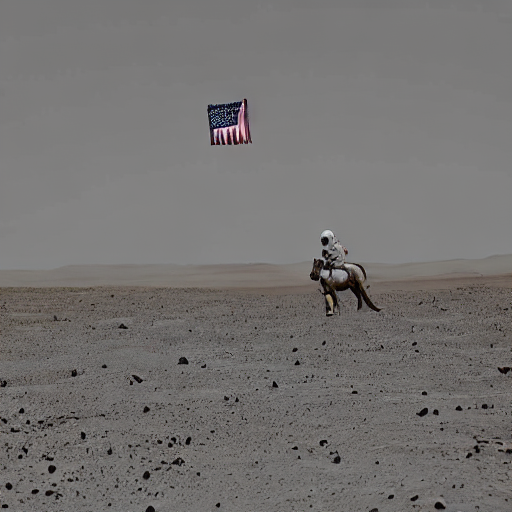

In [ ]:
image

#### Mis-use Stable Diffusion

Actual Song

In [ ]:
# load toto-africa.wav from local
y, sr = librosa.load("/content/drive/MyDrive/Data_Music_Generation/toto-africa.wav", sr=44100)

In [ ]:
# take data between 5s and 10s
y_data = y[4*44100:9*44100]

In [ ]:
Audio(y_data, rate=params_mono.sample_rate)

Create Song from Song + Prompt 

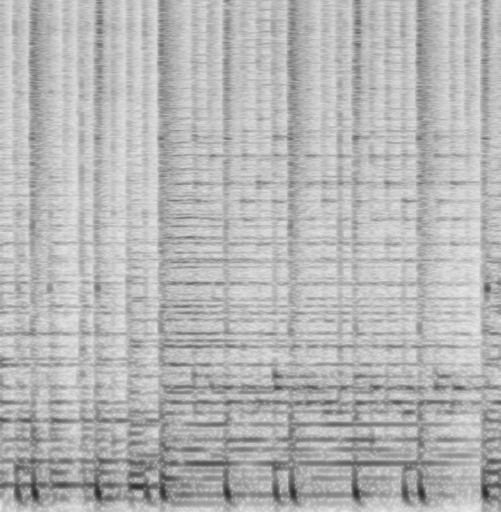

In [ ]:
spec_new_data = spectrogram_from_waveform(y_data, params_mono)
power_for_image = 0.25
max_volume = np.ceil(np.power(np.max(spec_new_data),power_for_image)) # max volume depends on our audio recoding conditions
image_new = image_from_spectrogram(spec_new_data,params_mono, max_volume=max_volume)
image_new

In [ ]:
# Alternative Conversion
#im2wave = y_data
#wave2spec = spectrogram_from_waveform(im2wave, params_mono)
#image_new = image_from_spectrogram(wave2spec, params_mono)

In [ ]:
components = pipe.components
riffusion_img2img = StableDiffusionImg2ImgPipeline(**components)

In [ ]:
prompt = "Make it more psychedelic"
generator = torch.Generator("cpu").manual_seed(42)

  0%|          | 0/5 [00:00<?, ?it/s]

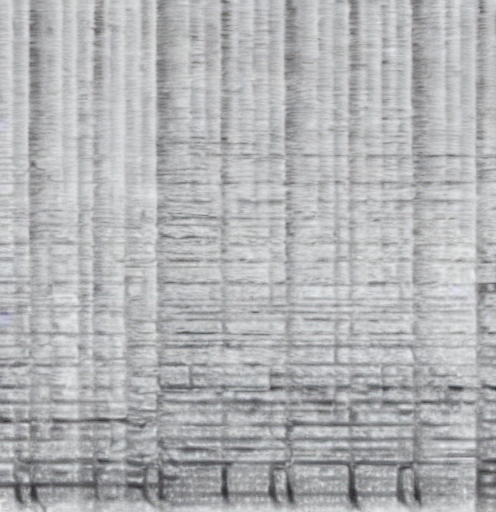

In [ ]:
specgram_mod_1 = riffusion_img2img(prompt=prompt, image=image_new, strength=0.1, guidance_scale=8.5).images[0]
specgram_mod_1

In [ ]:
specgram_mod_1.save("Full-strength.png")

In [ ]:
spec2im = spectrogram_from_image(specgram_mod_1, params_mono)

In [ ]:
im2wave = waveform_from_spectrogram(spec2im, params_mono)

In [ ]:
from IPython.display import Audio

In [ ]:
import soundfile as sf

# Let's assume `im2wave` is your audio data and `params_mono.sample_rate` is the sample rate
sf.write('output_high_strength.wav', im2wave, params_mono.sample_rate)

In [ ]:
sound = Audio(im2wave, rate=params_mono.sample_rate)
sound